# Experimenting with ML models
In this notebook, I'm experimenting with a few different models, to see which might be the most favorable option

In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest

In [97]:
# Read in data
path = '../data/guitars.csv'
guitars = pd.read_csv(path)

In [98]:
# Remove crazy outliers above $10,000
guitars = guitars.drop(index=guitars.loc[guitars['Price'] > 9999.99].index)

In [83]:
def wrangle(X):
    '''Bulk wrangle for split data'''
    
    # Avoid setting with copy
    X = X.copy()
    
    # Set feature thresholds
    model_limit = 50
    brand_limit = 50
    color_limit = 100
    material_limit = 50
    btype_limit = 30
    size_limit = 10
    pline_limit = 50
    
    # Clean conditions column text
    X['Condition'] = X['Condition'].str.replace('\:\D+', '')
    
    # Make null values out of the incorrectly entered categories
    conditions = ['Used', 'New', 'Open box', 'Seller refurbished',
                  'For parts or not working', 'Manufacturer refurbished']
    
    X.loc[~X['Condition'].isin(conditions), 'Condition'] = np.nan
    
    # Combine columns that are obviously the same and where values are null
    to_merge = {'Right-/ Left-Handed': ['Dexterity', 'Hand'],
                'Country/Region of Manufacture': ['Country of Manufacture'], 
                'Body Color': ['Color'], 'Body Type': ['Type']}
    for main_feat, dup_feat in to_merge.items():
        for f in dup_feat:
            condition = X[main_feat].isnull() & ~X[f].isnull()
            X.loc[condition, main_feat] = X[f]
            # Drop column after merge
        X = X.drop(columns=dup_feat)
    
    # TODO: fix right-left hand business
    # Reduce categories in the right-/ left hand column
    X['Orientation'] = X['Right-/ Left-Handed'].str.upper()
    X['Orientation'] = X['Orientation'].str.replace(
        '(RIGHT OR LEFT|LEFT OR RIGHT|EITHER|LAP|RIGHT-HANDED,).*', 
        'BOTH')
    X['Orientation'] = X['Orientation'].str.replace(
        'R.*', 'RIGHT-HANDED')
    X['Orientation'] = X['Orientation'].str.replace(
        'L.*', 'LEFT-HANDED')
    
    # Remove names that aren't real models from top 100
    X['Model'] = X['Model'].str.upper()
    not_a_model = ['DRN979CTV LH BK 2ND', '39" ELECTRIC GUITAR', '2019',
                   'DOES NOT APPLY', 'UNKNOWN', 'GTR235 LH BK 2ND']  
    top_models = X['Model'].value_counts()[:model_limit].index
    
    X.loc[X['Model'].isin(not_a_model), 'Model'] = 'OTHER'
    X.loc[~X['Model'].isin(top_models), 'Model'] = 'OTHER'
    
    # Clean and shrink the brand column
    X['Brand'] = X['Brand'].str.upper()
    X['Brand'] = X['Brand'].str.replace('UNBRANDED.*', 'UNBRANDED')
    top_brands = X['Brand'].value_counts()[:brand_limit].index
    X.loc[~X['Brand'].isin(top_brands), 'Brand'] = 'OTHER'
    
    # Clean and shrink cardinality of the string configuration column
    standard_configs = ['6 STRING', '7 STRING', '8 STRING', '9 STRING', '12 STRING']
    
    X['String Configuration'] = X['String Configuration'].str.upper()
    X['String Configuration'] = X['String Configuration'].str.replace(
        '6\W*STRING(?!78912).*|^6$|6\s*\w*\s*STRINGS(?!78912)', '6 STRING')
    X['String Configuration'] = X['String Configuration'].str.replace('^7$', '7 STRING')
    X['String Configuration'] = X['String Configuration'].str.replace('12\W*STRING', '12 STRING')
    
    X.loc[~X['String Configuration'].isin(standard_configs), 'String Configuration'] = 'OTHER'
    
    # Turn UPC and MPN into included and not included categories
    X['UPC'] = X['UPC'].str.upper()
    X.loc[X['UPC'] != 'DOES NOT APPLY', 'UPC'] = 'PROVIDED'
    X.loc[X['UPC'] == 'DOES NOT APPLY', 'UPC'] = 'NOT AVAILABLE'
    
    # If MPN entry contains a digit, it can be considered a valid entry
    mpn_condition = X['MPN'].str.contains('\d')
    X.loc[mpn_condition == True, 'MPN'] = 'PROVIDED'
    X.loc[mpn_condition == False, 'MPN'] = 'NOT AVAILABLE'
    
    # Reduce size, color and material and product line cardinality
    features_limits = {'Body Color': color_limit,
                       'Body Material': material_limit,
                       'Size': size_limit,
                       'Product Line': pline_limit}
    
    for feat, lim in features_limits.items(): # Apply the same wrangling to 3 features
        X[feat] = X[feat].str.upper()
        top = X[feat].value_counts()[:lim].index
        X.loc[~X[feat].isin(top), feat] = 'OTHER'
    
    # Reduce body type cardinality
    X['Body Type'] = X['Body Type'].str.upper()
    top_btypes = X['Body Type'].value_counts().index[:btype_limit]
    X['Body Type'].str.replace('STRAT.*', 'STRATOCASTER')
    X.loc[~X['Body Type'].isin(top_btypes), 'Body Type'] = 'OTHER'
    
    # Make model year a numeric category
    X.loc[X['Model Year'].str.contains('^\d{4}$') == False, 'Model Year'] = np.nan
    X['Model Year'] = pd.to_numeric(X['Model Year'])    
    
    return X

### Beginning With a Baseline
The mean absolute error produced by guessing will help to establish a baseline to begin improving upon. What is the mean absolute error produced by predicting the mean price for every sample

In [51]:
# Start with a baseline
error = guitars['Price'] - guitars['Price'].mean()
mae = error.abs().mean()
print(f'Mean Absolute Error: ${mae:.2f}')

Mean Absolute Error: $505.91


Off by $500 isn't terrible, but for some guitar sales on eBay, that may be completely off the mark, like in the case of guitars sold for ridiculously low prices, i.e. for parts or not working.

### Exploring ML models
Just for comparison's sake, I'm exploring the error produced by a few regression techniques with default parameters. 

In [99]:
# Split into train and test in preparation for cross-validation
train, test = train_test_split(guitars, train_size=0.8, random_state=42)

# Apply wrangling to train and test
train = wrangle(train)
test = wrangle(test)

In [100]:
train.shape, test.shape

((9956, 33), (2489, 33))

In [101]:
# Arrange data into X_train and y_train for CV
target = 'Price'
features = ['Model', 'MPN', 'Body Color', 'Brand', 
            'UPC', 'Body Material', 'Body Type', 
            'Model Year', 'Size', 'Country/Region of Manufacture',
            'String Configuration', 'Orientation', 
            'Product Line','Condition']
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [87]:
# Fit pipeline for a basic Linear Regression, get cross validated erro

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression, k=40),
    LinearRegression()
)

k=3
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print(f'Mean of {k} scores:', -scores.mean())

MAE for 3 folds: [399.66323671 424.92608286 416.1146166 ]
Mean of 3 scores: 413.5679787250571


An error of ~$400 is better than guessing, but not by enough. How does the error look with a random forest regressor?

In [88]:
# Fit pipeline for a random forest regressor, get cross validated error

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k=5
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print(f'Mean of {k} scores:', -scores.mean())

MAE for 5 folds: [292.82698315 323.60989948 336.87559167 312.69605078 305.17250817]
Mean of 5 scores: 314.23620665042574


~$300 gets even closer, but it's likely that things can be done to get even closer still, without overfitting the data. The price column is heavily right skewed, so there is some log transformation in order.

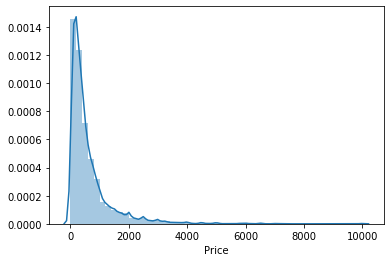

In [10]:
# Visualize skew in price
import seaborn as sns
sns.distplot(y_train);

### Log Transformation
If I log transorm the price, the distribution looks a little more normal

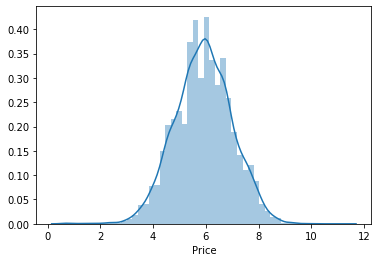

In [92]:
y_log = np.log1p(y_train)
sns.distplot(y_log);

Does the baseline error improve after this transformation?

In [93]:
error = y_log - y_log.mean()
mae_transformed = error.abs().mean()

# Untransform mae
mae = np.expm1(mae_transformed)
print(f'Mean Absolute Error of Log Transformed y: ${mae:.2f}')

Mean Absolute Error of Log Transformed y: $1.36


After transformation, the baseline gets down to less than $2 of error. Does that mean that the models tried before will do much better than before with a log transformed price?

In [94]:
# Fit pipeline for a basic Linear Regression, get cross validated erro

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression, k=40),
    LinearRegression()
)

k=3
scores = cross_val_score(pipeline, X_train, y_log, cv=k,
                         scoring='neg_mean_absolute_error')
scores_untransformed = np.expm1(scores)
print(f'MAE for {k} folds:', -scores_untransformed)
print(f'Mean of {k} scores:', -scores_untransformed.mean())

MAE for 3 folds: [0.4594415  0.47395378 0.46821541]
Mean of 3 scores: 0.4672035637421595


Now the linear regression model's error is down below $1

In [95]:
# Fit pipeline for a random forest regressor, get cross validated error

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k=5
scores = cross_val_score(pipeline, X_train, y_log, cv=k,
                         scoring='neg_mean_absolute_error')
scores_untransformed = np.expm1(scores)
print(f'MAE for {k} folds:', -scores_untransformed)
print(f'Mean of {k} scores:', -scores_untransformed.mean())

MAE for 5 folds: [0.38653353 0.38874631 0.37980542 0.39411032 0.38616535]
Mean of 5 scores: 0.3870721859074081


With a random forest regressor, the error lies below 40 cents

### XGBoost and Permutation Importance

In [107]:
from xgboost import XGBRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [102]:
# Split again into train and validation set for permutation importances
train, val = train_test_split(train, train_size=0.8, random_state=42)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

train.shape, val.shape

((7964, 33), (1992, 33))

In the random forest model, what were the most important features? To answer this question, I'll use a permutation importance visualization to display the weight of each feature

In [103]:
# Use pipeline for transformers only
transformers = make_pipeline(
    ce.TargetEncoder(),
    SimpleImputer(),
)

# Log Transform y_train and y_val
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
X_train_transformed = transformers.fit_transform(X_train, y_train_log)
X_val_transformed = transformers.transform(X_val)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Fit the model to the transformed X_train and y_log
model.fit(X_train_transformed, y_train_log)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [104]:
%%time
# Calculate permutation importance
permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val_log)

CPU times: user 6.29 s, sys: 788 ms, total: 7.08 s
Wall time: 7.67 s


PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100

In [105]:
# Display permutation importances
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names# Show all
)

Weight,Feature
0.2654 ± 0.0102,Brand
0.1696 ± 0.0094,Country/Region of Manufacture
0.0640 ± 0.0141,Body Color
0.0505 ± 0.0055,Product Line
0.0491 ± 0.0087,Model Year
0.0393 ± 0.0058,Body Material
0.0370 ± 0.0079,Body Type
0.0359 ± 0.0065,Condition
0.0286 ± 0.0021,MPN
0.0278 ± 0.0040,Size


It Looks like all the features I had previously chosen have an considerable effect on price, namely Brand and Country/Region of Manufacture

In [129]:
# Fit XGBoost, stop early
encoder = ce.TargetEncoder()
X_train_encoded = encoder.fit_transform(X_train, y_train_log)
X_val_encoded = encoder.transform(X_val)

model = XGBRegressor(
    n_estimators=1000,
    random_state=42, 
    n_jobs=-1, 
    max_depth=16,
    learning_rate=0.5,
    )

eval_set = [(X_train_encoded, y_train_log),
            (X_val_encoded, y_val_log)]

model.fit(X_train_encoded, y_train_log,
          eval_set=eval_set,
          eval_metric='mae',
          early_stopping_rounds=100)

[18:18:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:2.7192	validation_1-mae:2.70726
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:1.40518	validation_1-mae:1.40405
[2]	validation_0-mae:0.80525	validation_1-mae:0.837536
[3]	validation_0-mae:0.531355	validation_1-mae:0.625026
[4]	validation_0-mae:0.406146	validation_1-mae:0.547118


/Users/josemarquez/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[5]	validation_0-mae:0.343097	validation_1-mae:0.521418
[6]	validation_0-mae:0.306695	validation_1-mae:0.514169
[7]	validation_0-mae:0.282287	validation_1-mae:0.513507
[8]	validation_0-mae:0.268371	validation_1-mae:0.511799
[9]	validation_0-mae:0.246633	validation_1-mae:0.508729
[10]	validation_0-mae:0.234228	validation_1-mae:0.506593
[11]	validation_0-mae:0.223106	validation_1-mae:0.505023
[12]	validation_0-mae:0.216661	validation_1-mae:0.504512
[13]	validation_0-mae:0.202302	validation_1-mae:0.50122
[14]	validation_0-mae:0.178663	validation_1-mae:0.498511
[15]	validation_0-mae:0.165482	validation_1-mae:0.499053
[16]	validation_0-mae:0.158745	validation_1-mae:0.498571
[17]	validation_0-mae:0.152963	validation_1-mae:0.497916
[18]	validation_0-mae:0.150241	validation_1-mae:0.497778
[19]	validation_0-mae:0.141787	validation_1-mae:0.498261
[20]	validation_0-mae:0.137316	validation_1-mae:0.498146
[21]	validation_0-mae:0.135772	validation_1-mae:0.498369
[22]	validation_0-mae:0.132467	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=16, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

The xgboost did not perform as well on the validation set as the cross validated, but this does not necessarily mean that it will perform poorly on the test set; the error is still below $1

In [137]:
from sklearn.metrics import mean_absolute_error, r2_score
y_pred = model.predict(X_val_encoded)
mae = mean_absolute_error(y_val_log, y_pred)
mae_untransformed = np.expm1(mae)
mae_untransformed

0.6423632447395284

What is the R^2 score?

In [138]:
r2_score(y_val_log, y_pred)

0.5223856147653485

### Partial Dependence Plots
How does Body Color affect the prediction? I had originally hypothesized that color would have an important effect on a buyer's perspective of the guitar's worth.

In [156]:
from pdpbox.pdp import pdp_isolate, pdp_plot
# TODO: Try using a model with one hot encoder to represent pdp for categorical variables
feature = 'Body Color'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    feature=feature
)

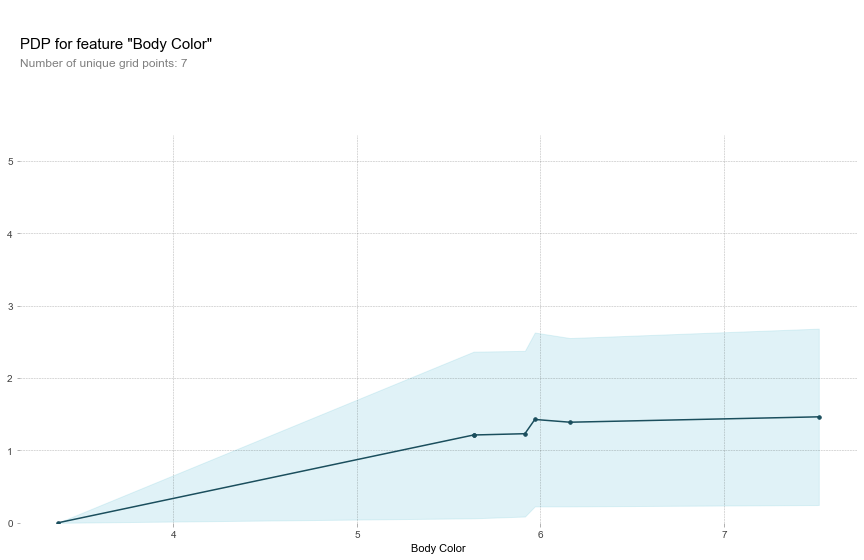

In [159]:
pdp_plot(isolated, feature_name=feature);

In [161]:
X_val_encoded

,Model,MPN,Body Color,Brand,UPC,Body Material,Body Type,Model Year,Size,Country/Region of Manufacture,String Configuration,Orientation,Product Line,Condition
6270,5.874768,5.641869,6.181127,4.792411,5.808758,6.311526,5.984205,2019.0,5.774949,5.658676,5.919246,5.967254,5.77336,5.556898
11920,5.699115,5.881134,5.635791,4.938193,5.808758,5.810445,5.984205,NaN,5.774949,5.541525,5.919246,5.967254,5.77336,6.004445
2389,6.306003,6.036769,6.042825,5.657533,5.976617,5.810445,5.984205,NaN,5.973296,6.268540,5.919246,5.967254,5.77336,6.004445
3239,5.874768,5.881134,6.494312,5.368995,5.808758,5.810445,6.305679,NaN,5.973296,6.937353,5.919246,5.967254,5.77336,6.004445
3988,6.306003,6.036769,6.160667,5.851067,5.976617,5.810445,5.717499,NaN,5.973296,5.658676,5.919246,5.787917,5.77336,6.004445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978,5.874768,6.036769,5.957833,6.590881,5.976617,5.810445,5.984205,2016.0,5.774949,6.937353,6.022260,5.967254,5.77336,6.004445
8243,5.874768,5.881134,6.199153,5.657533,5.808758,6.892225,5.984205,2002.0,5.973296,5.658676,5.919246,5.967254,5.77336,6.004445
5865,5.874768,6.036769,6.043294,5.657533,5.976617,5.810445,5.984205,NaN,5.973296,5.658676,5.919246,5.967254,5.77336,6.004445
2308,5.874768,6.036769,5.969624,7.031513,5.976617,5.810445,5.717499,NaN,5.973296,5.658676,5.919246,5.967254,5.77336,6.004445
